# **Nuclei Segmentation - UNET Model**

In [3]:
###############
# Environment #
###############
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report
from keras import backend as K

import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#####################
# Default Parameter #
#####################
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = './stage1_train/'
TEST_PATH = './stage1_test/'

warnings.filterwarnings('ignore', category = UserWarning, module = 'skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [4]:
##########################
# Get Train and Test IDs #
##########################
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

########################
# Get and Resize Image #
########################
# Train
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)
sys.stdout.flush()

for n, id_ in tqdm(enumerate(train_ids), total = len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode = 'constant', preserve_range = True)
    X_train[n] = img
    
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode = 'constant', 
                                      preserve_range = True), axis = -1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Test
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
sizes_test = []
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total = len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode = 'constant', preserve_range = True)
    X_test[n] = img

100%|██████████| 65/65 [00:01<00:00, 44.15it/s]


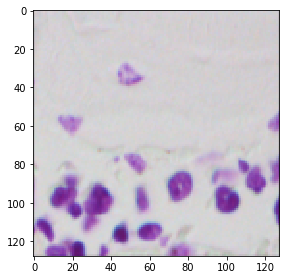

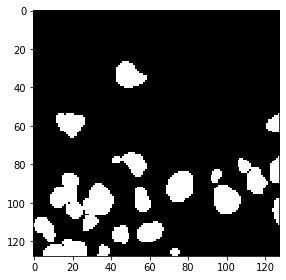

In [3]:
#################
# Data Checking #
#################
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [4]:
#####################
# Define IoU Metric #
#####################
def iou_coef(y_true, y_pred, smooth = 1):
    intersection = K.sum(K.abs(y_true * y_pred), axis = [1,2,3])
    union = K.sum(y_true,[1,2,3]) + K.sum(y_pred,[1,2,3]) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis = 0)
    return iou

In [5]:
######################
# Dice Score Metrics #
######################
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

In [6]:
#####################
# Build U-Net Model #
#####################
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same') (c4)
p4 = MaxPooling2D(pool_size = (2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides = (2, 2), padding = 'same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides = (2, 2), padding = 'same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides = (2, 2), padding = 'same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides = (2, 2), padding = 'same') (c8)
u9 = concatenate([u9, c1], axis = 3)
c9 = Conv2D(16, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation = 'elu', kernel_initializer = 'he_normal', padding = 'same') (c9)

outputs = Conv2D(1, (1, 1), activation = 'sigmoid') (c9)

model = Model(inputs=[inputs], outputs = [outputs])
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [dice_coef])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [7]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(factor = 0.5, 
                              min_lr = 1e-12, 
                              monitor = 'val_loss', 
                              patience = 5, 
                              verbose = 1)

In [8]:
#############
# Fit model #
#############
earlystopper = EarlyStopping(patience = 30, verbose = 1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose = 1, save_best_only = True)
results = model.fit(X_train, Y_train, validation_split = 0.1, batch_size = 16, epochs = 300, 
                    callbacks = [earlystopper, checkpointer, reduce_lr])

Train on 603 samples, validate on 67 samples
Epoch 1/300
603/603 [==============================] - 39s 64ms/step - loss: 0.4421 - dice_coef: 0.3472 - val_loss: 0.2394 - val_dice_coef: 0.6154

Epoch 00001: val_loss improved from inf to 0.23941, saving model to model-dsbowl2018-1.h5
Epoch 2/300
603/603 [==============================] - 3s 4ms/step - loss: 0.1979 - dice_coef: 0.6514 - val_loss: 0.1737 - val_dice_coef: 0.7669

Epoch 00002: val_loss improved from 0.23941 to 0.17369, saving model to model-dsbowl2018-1.h5
Epoch 3/300
603/603 [==============================] - 3s 4ms/step - loss: 0.1473 - dice_coef: 0.7520 - val_loss: 0.1567 - val_dice_coef: 0.7958

Epoch 00003: val_loss improved from 0.17369 to 0.15672, saving model to model-dsbowl2018-1.h5
Epoch 4/300
603/603 [==============================] - 3s 4ms/step - loss: 0.1271 - dice_coef: 0.7881 - val_loss: 0.1249 - val_dice_coef: 0.8185

Epoch 00004: val_loss improved from 0.15672 to 0.12491, saving model to model-dsbowl2018-1.


Epoch 00037: val_loss did not improve from 0.07206
Epoch 38/300
603/603 [==============================] - 3s 4ms/step - loss: 0.0691 - dice_coef: 0.8853 - val_loss: 0.0736 - val_dice_coef: 0.8969

Epoch 00038: val_loss did not improve from 0.07206
Epoch 39/300
603/603 [==============================] - 3s 4ms/step - loss: 0.0686 - dice_coef: 0.8865 - val_loss: 0.0738 - val_dice_coef: 0.8940

Epoch 00039: val_loss did not improve from 0.07206
Epoch 40/300
603/603 [==============================] - 3s 4ms/step - loss: 0.0676 - dice_coef: 0.8883 - val_loss: 0.0739 - val_dice_coef: 0.9001

Epoch 00040: val_loss did not improve from 0.07206

Epoch 00040: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 41/300
603/603 [==============================] - 3s 4ms/step - loss: 0.0652 - dice_coef: 0.8920 - val_loss: 0.0767 - val_dice_coef: 0.8958

Epoch 00041: val_loss did not improve from 0.07206
Epoch 42/300
603/603 [==============================] - 3s 4ms/step - loss:

In [9]:
##############
# Prediction #
##############
model = load_model('model-dsbowl2018-1.h5', custom_objects = {'dice_coef': dice_coef})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose = 1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose = 1)
preds_test = model.predict(X_test, verbose = 1)

#############
# Threshold #
#############
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

#######################################
# Create list of upsampled test masks #
#######################################
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode = 'constant', preserve_range = True))

65/65 [==============================] - 6s 92ms/step


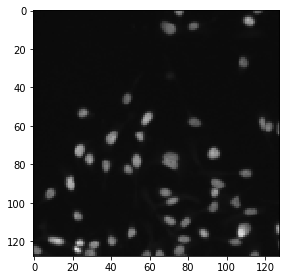

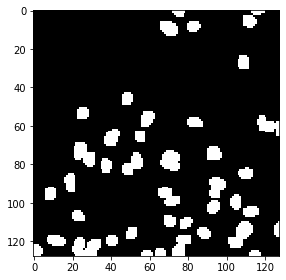

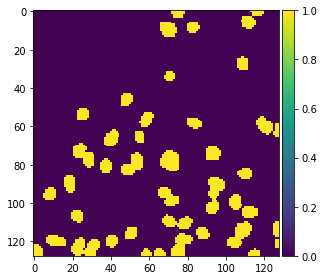

In [10]:
##########################################################
# Perform a sanity check on some random training samples #
##########################################################
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

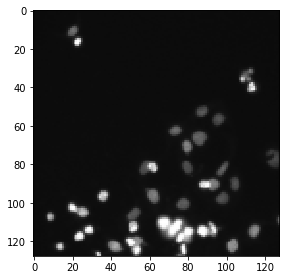

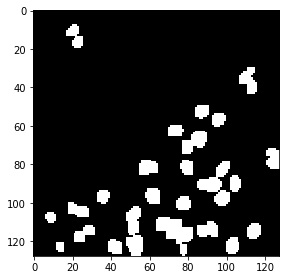

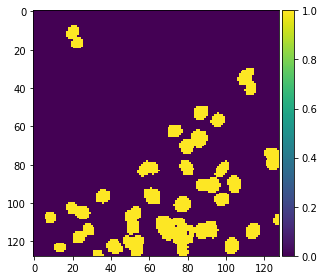

In [11]:
############################################################
# Perform a sanity check on some random validation samples #
############################################################
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [12]:
train_loss = results.history["loss"]
valid_loss = results.history["val_loss"]
train_acc = results.history["dice_coef"]
valid_acc = results.history["val_dice_coef"]

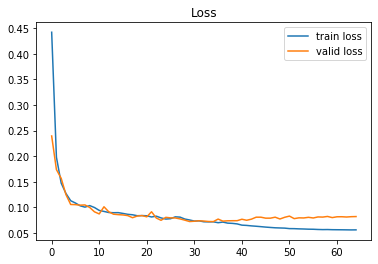

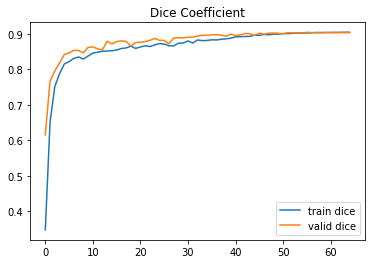

In [13]:
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label = "train loss")
plt.plot(range(len(valid_loss)), valid_loss, label = "valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label = "train dice")
plt.plot(range(len(valid_acc)), valid_acc, label = "valid dice")
plt.legend()
plt.title("Dice Coefficient")
plt.show()